# Introduction to ARIMA Models

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained below. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

# AR(p)
# Autoregressive Model
In a moving average model as we saw with Holt-Winters, we forecast the variable of interest using a linear combination of predictors. In our example we forecasted numbers of airline passengers in thousands based on a set of level, trend and seasonal predictors.

In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coeffients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>
Specifically, for an <strong>AR(1)</strong> model: $-1 \lt \phi_1 \lt 1$<br>
and for an <strong>AR(2)</strong> model: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Models <strong>AR(3)</strong> and higher become mathematically very complex. Fortunately statsmodels does all the heavy lifting for us.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.AR.html'>ar_model.AR</a></strong><font color=black>(endog[, dates, freq, missing])</font>&nbsp;&nbsp;Autoregressive AR(p) model<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.ar_model.ARResults.html'>ar_model.ARResults</a></strong><font color=black>(model, params[, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Class to hold results from fitting an AR model</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://otexts.com/fpp2/AR.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive models</font><br>
<strong>
<a href='https://en.wikipedia.org/wiki/Autoregressive_model'>Wikipedia</a></strong>&nbsp;&nbsp;<font color=black>Autoregressive model</font></div>

## Perform standard imports and load datasets
For this exercise we'll look at monthly U.S. population estimates in thousands from January 2011 to December 2018 (96 records, 8 years of data). Population includes resident population plus armed forces overseas. The monthly estimate is the average of estimates for the first of the month and the first of the following month.
Source: https://fred.stlouisfed.org/series/POPTHM

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR, ARResults

# Load the U.S. Population dataset
df = pd.read_csv('uspopulation.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'

In [2]:
df.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


## Plot the source data

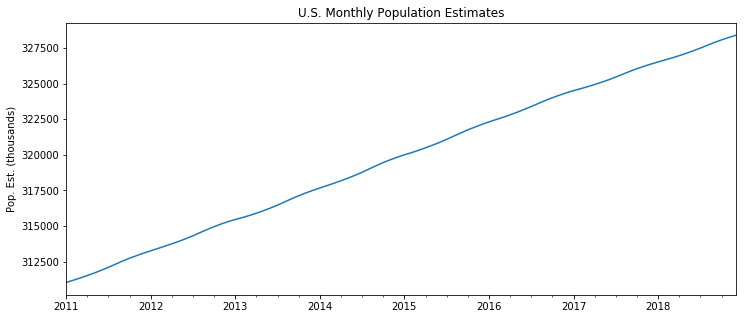

In [3]:
title='U.S. Monthly Population Estimates'
ylabel='Pop. Est. (thousands)'
xlabel='' # we don't really need a label here

ax = df['PopEst'].plot(figsize=(12,5),title=title);
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Split the data into train/test sets
The goal in this section is to:
* Split known data into a training set of records on which to fit the model
* Use the remaining records for testing, to evaluate the model
* Fit the model again on the <em>full</em> set of records
* Predict a future set of values using the model

As a general rule you should set the length of your test set equal to your intended forecast size. That is, for a monthly dataset you might want to forecast out one more year. Therefore your test set should be one year long.

<div class="alert alert-info"><strong>NOTE: </strong>For many training and testing applications we would use the <tt>train_test_split()</tt> function available from Python's <a href='https://scikit-learn.org/stable/'>scikit-learn</a> library. This won't work here as <tt>train_test_split()</tt> takes <em>random samples</em> of data from the population.</div>

In [4]:
len(df)

96

In [5]:
# Set one year for testing
train = df.iloc[:84]
test = df.iloc[84:]

## Fit an AR(1) Model

In [6]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
model = AR(train['PopEst'])
AR1fit = model.fit(maxlag=1, method='mle')
print(f'Lag: {AR1fit.k_ar}')                 #order or lag k of AR model
print(f'Coefficients:\n {AR1fit.params}')

Lag: 1
Coefficients:
 const        141.703434
L1.PopEst      0.999555
dtype: float64


<div class="alert alert-info"><strong>NOTE: </strong>There's a slight difference between the object returned by the Holt-Winters Exponential Smoothing <tt>.fit()</tt> method and that returned by AR. The Holt-Winters object uses <tt>.forecast()</tt> for predicted values, while AR uses <tt>.predict()</tt>.</div>

In [8]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

In [9]:
predictions1

2018-01-01    326374.399323
2018-02-01    326370.800248
2018-03-01    326367.202777
2018-04-01    326363.606906
2018-05-01    326360.012637
2018-06-01    326356.419968
2018-07-01    326352.828898
2018-08-01    326349.239427
2018-09-01    326345.651554
2018-10-01    326342.065278
2018-11-01    326338.480599
2018-12-01    326334.897516
Freq: MS, Name: AR(1) Predictions, dtype: float64

In [10]:
# Comparing predictions to expected values
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]}, expected={test['PopEst'][i]}")
    #print(f"predicted={predictions1[i]:<11.10}, expected={test['PopEst'][i]}")  #If we restrict the number of decimals then use :<11.10 

predicted=326374.39932272787, expected=326527
predicted=326370.8002484842, expected=326669
predicted=326367.20277655526, expected=326812
predicted=326363.6069062277, expected=326968
predicted=326360.01263678854, expected=327134
predicted=326356.419967525, expected=327312
predicted=326352.8288977247, expected=327502
predicted=326349.23942667554, expected=327698
predicted=326345.6515536658, expected=327893
predicted=326342.065277984, expected=328077
predicted=326338.480598919, expected=328241
predicted=326334.89751576, expected=328393


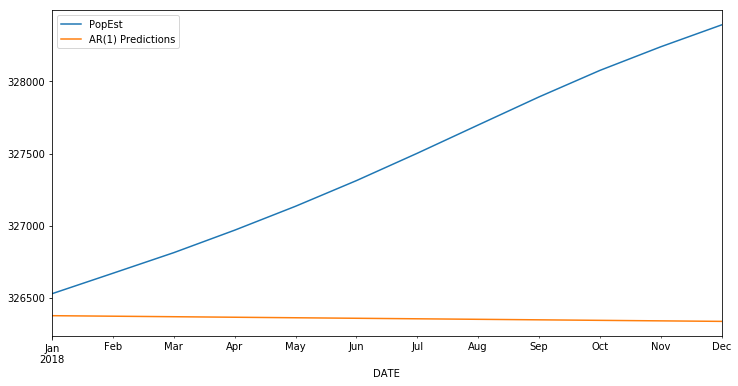

In [11]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

## Fit an AR(2) Model

In [12]:
# Recall that our model was already created above based on the training set
AR2fit = model.fit(maxlag=2,method='mle')
print(f'Lag: {AR2fit.k_ar}')
print(f'Coefficients:\n{AR2fit.params}')

Lag: 2
Coefficients:
const        125.160202
L1.PopEst      1.996434
L2.PopEst     -0.996826
dtype: float64


In [13]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

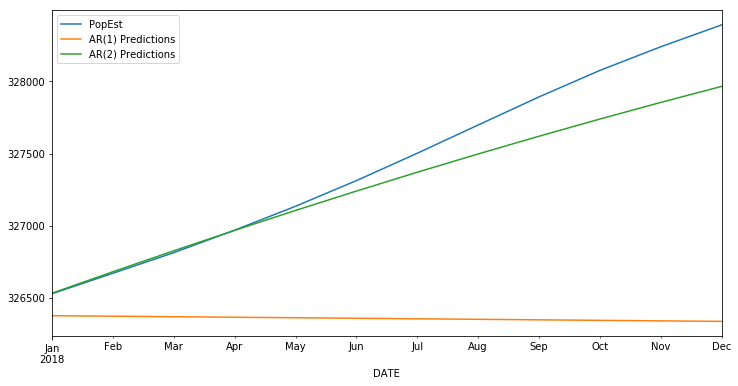

In [14]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

## Fit an AR(p) model where statsmodels chooses p
This time we'll omit the <tt>maxlag</tt> argument in <tt>AR.fit()</tt> and let statsmodels choose a p-value for us.

In [15]:
ARfit = model.fit(method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 11
Coefficients:
const         96.157899
L1.PopEst      2.368851
L2.PopEst     -2.324145
L3.PopEst      1.841479
L4.PopEst     -1.514055
L5.PopEst      1.032265
L6.PopEst     -1.069012
L7.PopEst      1.046841
L8.PopEst     -0.392732
L9.PopEst      0.239733
L10.PopEst    -0.245166
L11.PopEst     0.015639
dtype: float64


In [16]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(11) Predictions'

predictions11 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

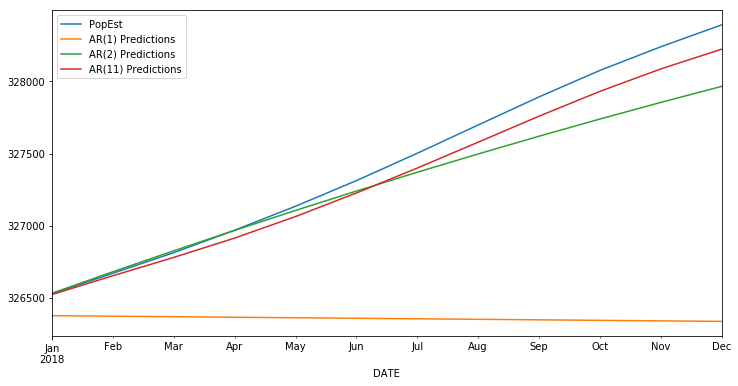

In [17]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions11.plot(legend=True,figsize=(12,6));

## Evaluate the Model
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn.

In [18]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(11)']
preds = [predictions1, predictions2, predictions11]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error:  1548911.35
AR(2) Error: 48666.30134
AR(11) Error: 11067.63812


We see right away how well AR(11) outperformed the other two models.

Another method is the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> (AIC), which does a better job of evaluating models by avoiding overfitting.<br>
Fortunately this is available directly from the fit model object.

In [19]:
modls = [AR1fit,AR2fit,ARfit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 3.4273
AR(2) AIC: 3.4511
AR(11) AIC: 3.6654


## Forecasting
Now we're ready to train our best model on the greatest amount of data, and fit it to future dates.

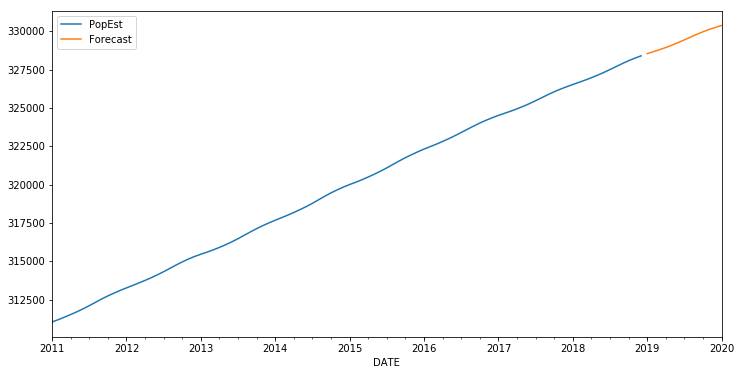

In [20]:
# First, retrain the model on the full dataset
model = AR(df['PopEst'])

# Next, fit the model
ARfit = model.fit(maxlag=11,method='mle')

# Make predictions for 12 months in future. ie. end=len(df)+12
fcast = ARfit.predict(start=len(df), end=len(df)+12, dynamic=False).rename('Forecast')

# Plot the results
df['PopEst'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,6));